In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import requests
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import re

# Mathematics

In the three-body problem, the force that acts for example in the body 1 can be expressed like this:
$\begin{align}
    \mathbf{F}_1= \frac{d^2\hat{r}_{1}}{dt^2}m_1 = G m_1 m_2 \frac{\hat{r}_{2}-\hat{r}_{1}}{|\hat{r}_{2}-\hat{r}_{1}|^3}+ G m_1 m_3\frac{\hat{r}_{3}-\hat{r}_{1}}{|\hat{r}_{3}-\hat{r}_{1}|^3}\\
    \frac{d^2\hat{r}_{1}}{dt^2}=G m_2 \frac{\hat{r}_{2}-\hat{r}_{1}}{|\hat{r}_{2}-\hat{r}_{1}|^3}+ G m_3\frac{\hat{r}_{3}-\hat{r}_{1}}{|\hat{r}_{3}-\hat{r}_{1}|}
\end{align}$

There is a pattern when we add more bodies to the problem. Therefore, the problem of N-Body can be expressed as:

$
\begin{align}
\frac{d^2\hat{r}_{i}}{dt^2}= \sum_{j\neq i}^N G m_j \frac{\hat{r}_{j}-\hat{r}_{i}}{|\hat{r}_{j}-\hat{r}_{i}|^3}\\
\end{align}
$

As an ODE system:
$
\begin{align}
\frac{d\hat{v}_{i}}{dt}= \sum_{j\neq i}^N G m_j \frac{\hat{r}_{j}-\hat{r}_{i}}{|\hat{r}_{j}-\hat{r}_{i}|^3}\quad\quad \frac{d\hat{r}_{i}}{dt}=\hat{v}_{i}\\
\end{align}
$

**Normalization**       
I might need to normalize the data. This because when i try this with real data and real planets (HORIZON´s API) the values of distance between objects, masses and times and incredibly high and this lets to two consequences: 1º the function that solves these equations, solve_ivp, does not converge and 2º this variables are dificult to put into context. Due to this, i will normalize the data from distance (km), GM(km^3/s^2) and time (s) to distance (AU), GM(AU^3/days^2) and time (days):
$
\begin{align}
\hat{r}_{i}(AU)=\hat{r}_{i}(km) \frac{1AU}{149597870.700 km}\notag\\
Gm_i(AU^3/days^2)=Gm_i(km^3/s^2)\frac{(1 AU)^3}{(1 day)^2}\frac{(3600\cdot 24 s)^2}{(149597870.700 km)^3}\notag\\
\hat{v}_{i}(AU/day)=\hat{v}_{i}(km/s)\frac{1 AU}{1 day}\frac{3600\cdot 24 s}{149597870.700 km}\\
\end{align}
$


# Tipical 3 Body problem
Initial conditions

In [2]:
m1 = 1.0
m2 = 1.0
m3 = 1.0

# Position
inital_position_1 =  [1.0,  0.0,  1.0]
inital_position_2 =  [1.0,  1.0,  0.0]
inital_position_3 =  [0.0,   0.0, 1.0]

# Velocity
inital_velocity_1 =  [0.0, 0.0, 1.0]
inital_velocity_2 =  [0.0, 0.0, -1.0]
inital_velocity_3 =  [0.0, 0.0, -0.6]

initial_conditions = np.array([
    inital_position_1, inital_position_2, inital_position_3,
    inital_velocity_1, inital_velocity_2, inital_velocity_3
]).ravel()

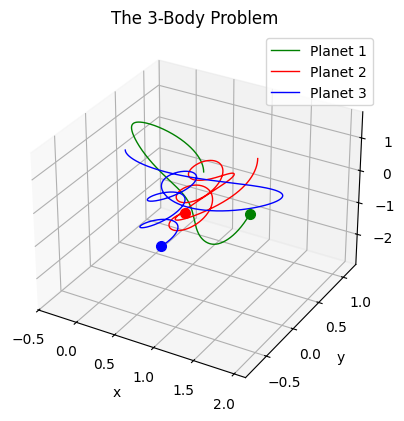

In [ ]:
G=1
def system_odes(t, S, m1, m2, m3):
    r1, r2, r3 = S[0:3], S[3:6], S[6:9]
    dr1_dt, dr2_dt, dr3_dt = S[9:12], S[12:15], S[15:18]

    v1, v2, v3 = dr1_dt, dr2_dt, dr3_dt

    dv1_dt = G*m3*(r3 - r1)/np.linalg.norm(r3 - r1)**3 + G*m2*(r2 - r1)/np.linalg.norm(r2 - r1)**3
    dv2_dt = G*m3*(r3 - r2)/np.linalg.norm(r3 - r2)**3 + G*m1*(r1 - r2)/np.linalg.norm(r1 - r2)**3
    dv3_dt = G*m1*(r1 - r3)/np.linalg.norm(r1 - r3)**3 + G*m2*(r2 - r3)/np.linalg.norm(r2 - r3)**3

    return np.array([v1, v2, v3, dv1_dt, dv2_dt, dv3_dt]).ravel()

time_ini, time_end = 0, 10
t_points = np.linspace(time_ini, time_end, 501)

solution = solve_ivp(fun=system_odes,t_span=(time_ini, time_end),y0=initial_conditions,t_eval=t_points,args=(m1, m2, m3))

t_sol = solution.t
p1x_sol = solution.y[0]
p1y_sol = solution.y[1]
p1z_sol = solution.y[2]

p2x_sol = solution.y[3]
p2y_sol = solution.y[4]
p2z_sol = solution.y[5]

p3x_sol = solution.y[6]
p3y_sol = solution.y[7]
p3z_sol = solution.y[8]

###################  Plots ###################  

fig, ax = plt.subplots(subplot_kw={"projection":"3d"})

planet1_plt, = ax.plot(p1x_sol, p1y_sol, p1z_sol, 'green', label='Planet 1', linewidth=1)
planet2_plt, = ax.plot(p2x_sol, p2y_sol, p2z_sol, 'red', label='Planet 2', linewidth=1)
planet3_plt, = ax.plot(p3x_sol, p3y_sol, p3z_sol, 'blue',label='Planet 3', linewidth=1)

planet1_dot, = ax.plot([p1x_sol[-1]], [p1y_sol[-1]], [p1z_sol[-1]], 'o', color='green', markersize=7)
planet2_dot, = ax.plot([p2x_sol[-1]], [p2y_sol[-1]], [p2z_sol[-1]], 'o', color='red', markersize=7)
planet3_dot, = ax.plot([p3x_sol[-1]], [p3y_sol[-1]], [p3z_sol[-1]], 'o', color='blue', markersize=7)


ax.set_title("The 3-Body Problem")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.grid()
plt.legend()
plt.show()

# N-Body Problem

In [ ]:
class body:
    '''   
    CLASS: base class that defines the characteristics of a body

    PARAMS:
    Gmass : G*M (G gravitational force constant, M mass of the body) km**3/s**2
    velocity: np.array([vx,vy,vz]) km/s
    position : np.array([x,y,z]) km
    name='' : name of the body
    normalized=None : True if there is a unit normalization needed, for example to optimize the calculations
    '''

    def __init__(self,Gmass,velocity,position,name='',normalized=None):
        au= 149597870.700#km
        factor_day=3600*24
        factor_year=factor_day*365
        if normalized:
            factor_v=factor_day/au
            factor_d=1/au
            factor_gm=factor_day**2/au**3
        self.name=name
        self.Gmass=Gmass*factor_gm
        self.velocity=velocity*factor_v
        self.position=position*factor_d

class session():
    '''   
    CLASS: base class for the interaction of the N-bodies added to it
    '''

    def __init__(self):
        self.total_bodies=[]
        self.num_bodies=0

    def add_body(self,Gmass,velocity,position,name='',normalized=None):
        ''' 
        FUNCTION: create body(CLASS) and add it to the total_bodies list
        '''
        body_added=body(Gmass,velocity,position,name,normalized)
        if self.check_body_position(body_added):
            self.total_bodies.append(body_added)
            self.num_bodies+=1
    
    def check_body_position(self,newBody):
        ''' 
        FUNCTION: check that the body is not already added
        '''
        for bod in self.total_bodies:

            if (newBody.position==bod.position).all():

                print(f'The body {newBody.name} has the same position as {bod.name}')

                return False
            
        return True


    def info(self):
        ''' 
        FUNCTION: print the bodies added info
        '''
        for bod in self.total_bodies:
            print(bod.name,' mass',bod.Gmass,' p',bod.position,' v',bod.velocity)

    def create_inputs(self):
        ''' 
        FUNCTION: create inputs from the bodies data to the solve_ivp function
        '''
        p=[]
        v=[]
        m=[]
        for bod in self.total_bodies:
            p.append(bod.position)
            v.append(bod.velocity)
            m.append(bod.Gmass)
        return np.array(p+v).ravel(),m

    def n_bodies_calculation(self,t,inputs,Gmasses):
        ''' 
        FUNCTION: creates the funtion to calculate the N-bodies problem
        '''
        num_bod=self.num_bodies
        positions = inputs[:3*num_bod].reshape((num_bod, 3))  # get positions
        velocities = inputs[3*num_bod:].reshape((num_bod, 3))  # get velocities

        d_positions_dt = velocities  # derivative of position = Velocity
        d_velocities_dt = np.zeros_like(positions)  # Init the aceleration

        for i in range(num_bod): #from the i body calc. all the interactions with the other bodies
           
           for j in range(num_bod):
               
               if i != j:  # dont calc. of himself
                   
                   r_ij = positions[j] - positions[i]  # distance vector
                   norm_r_ij = np.linalg.norm(r_ij)  # norm
                   d_velocities_dt[i] += Gmasses[j] * r_ij / norm_r_ij**3  # Gravitation law       

        return np.concatenate((d_positions_dt.flatten(), d_velocities_dt.flatten())).ravel() 
        
    def calc(self,t_span,t_eval):
        ''' 
        FUNCTION: solves the Gravitation law for N-Bodies with solve_ivp

        PARAMS:
            t_span : time interval [t_ini,t_end]
            t_eval : np.linspace(t_ini,t_end, number of steps)

        RETRURN:
         solution: dict, relevant keys: t for the temporal data and y for the position and velocity data

            solution.y: np.array shape(3*2*N-Bodies,number of steps)

            The solutions have this form:
            np.array(
                [x1,x2,x3,...,xt],[y1,y2,y3,...,yt],[z1,z2,z3,...,zt], #planet 1
                [x1,x2,x3,...,xt],[y1,y2,y3,...,yt],[z1,z2,z3,...,zt], #planet 2
                                            ...
                [vx1,vx2,vx3,...,xt],[vy1,vy2,vy3,...,vyt],[vz1,vz2,vz3,...,vzt], #planet 1
                [vx1,vx2,vx3,...,xt],[vy1,vy2,vy3,...,vyt],[vz1,vz2,vz3,...,vzt], #planet 2
                )
        '''
        inputs,Gmasses=self.create_inputs()
        start=time.time()
        solution = solve_ivp(fun=self.n_bodies_calculation, t_span=t_span, y0=inputs, t_eval=t_eval, args=(Gmasses,), method='BDF')
        print('Calc time: ',round(time.time()-start,4))

        return solution
    
    def plot_solution(self,t_span,t_eval):
        ''' 
        FUNCTION: Calc. the solutuion and plot it
        '''
        solution=self.calc(t_span,t_eval)#calc. solution
        position_max=np.max(np.abs(solution.y[0:self.num_bodies*3]))#calc. the calculate the furthest distance
        colors = ['green', 'red', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'black', 'white', 'gray', 'cyan',
                   'magenta', 'lime', 'teal', 'indigo', 'violet', 'gold', 'silver', 'beige']
        
        fig=plt.figure(figsize=(15,6))
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
        
        ######### FIRST PLOT 3D #######################
        ax = fig.add_subplot(gs[0], projection='3d')
        for n_bod in range(self.num_bodies):

            #plot  the body orbit
            planet_plt, = ax.plot(solution.y[n_bod*3], solution.y[n_bod*3+1], solution.y[n_bod*3+2],colors[n_bod], label=self.total_bodies[n_bod].name, linewidth=1)
            #plot  the body last point/position
            planet_dot, = ax.plot([solution.y[n_bod*3][-1]], [solution.y[n_bod*3+1][-1]], [solution.y[n_bod*3+2][-1]], 'o', color=colors[n_bod], markersize=7)
        
        ax.set_title(f"The {self.num_bodies}-Body Problem : {t_span[-1]} days")
        ax.set_xlabel("x(AU)")
        ax.set_ylabel("y(AU)")
        ax.set_zlabel("z(AU)")
        ax.set_xlim([-position_max,position_max])
        ax.set_ylim([-position_max,position_max])
        ax.set_zlim([-position_max,position_max])
        plt.grid()
        plt.legend()

        ######### SECOND PLOT 2D #######################
        ax = fig.add_subplot(gs[1])
        for n_bod in range(self.num_bodies):
            
            #plot  the body orbit
            planet_plt, = ax.plot(solution.y[n_bod*3], solution.y[n_bod*3+1],colors[n_bod], label=self.total_bodies[n_bod].name, linewidth=1)
            #plot  the body last point/position
            planet_dot, = ax.plot([solution.y[n_bod*3][-1]], [solution.y[n_bod*3+1][-1]], 'o', color=colors[n_bod], markersize=7)

        ax.set_title(f"The {self.num_bodies}-Body Problem : {t_span[-1]} days")
        ax.set_xlabel("x(AU)")
        ax.set_ylabel("y(AU)")
        ax.set_xlim([-position_max,position_max])
        ax.set_ylim([-position_max,position_max])
        plt.grid()
        plt.legend()

        plt.show()

        return solution

Planeta 1  mass 1  p [1. 0. 1.]  v [0. 0. 1.]
Planeta 2  mass 1  p [1. 1. 0.]  v [ 0.  0. -1.]
Planeta 3  mass 1  p [0. 0. 1.]  v [ 0.   0.  -0.6]
Calc time:  0.0611


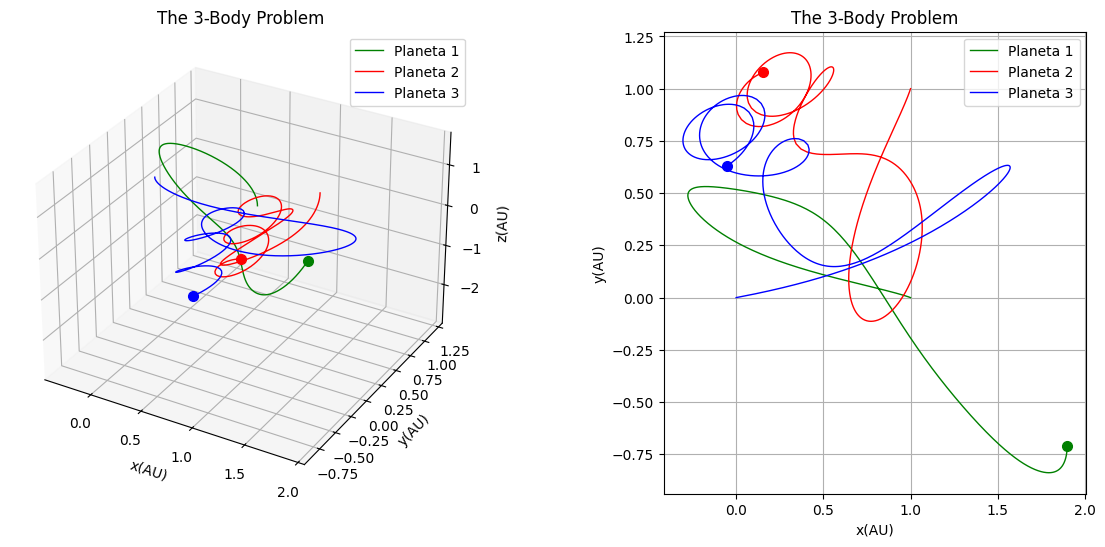

Calc time:  0.0716


In [ ]:
t_span = (0, 10)
t_points = np.linspace(0, 10, 1001)


sesion=session()
sesion.add_body(1,np.array(inital_velocity_1),np.array(inital_position_1),'Planeta 1')
sesion.add_body(1,np.array(inital_velocity_2),np.array(inital_position_2),'Planeta 2')
sesion.add_body(1,np.array(inital_velocity_3),np.array(inital_position_3),'Planeta 3')
sesion.info()
sol=sesion.plot_solution(t_span,t_points)

Same results, almost same time.

# API Horizon NASA
Lets add some real data using the API Horizon from the NASA

In [ ]:
def apiCall(bodyId,date):
    '''   
    FUNCTION: Calls to the HORIZON API and gets data from the desired date

    PARAMS:
        bodyId: Id of the body
        date: start date (YYYY-MM-DD)
    
    RETURNS:
        List line by line of text
    '''

    date_formated = datetime.strptime(date, '%Y-%m-%d')
    next_day = date_formated + timedelta(days=1)

    params = {
        'format': 'text',          # text o json, in this api they are the same
        'EPHEM_TYPE': 'VECTORS',
        'COMMAND': bodyId,              # Body ID, MB returns list of IDs
        'CENTER': '@ssb',        # ssb = barycenter of the solar system
        'STEP_SIZE': '1d',         # time interval
        'START_TIME': date,  # Init date(YYYY-MM-DD)
        'STOP_TIME': next_day.strftime('%Y-%m-%d'),   # end date
        "VEC_TABLE": "2",        
        "VEC_LABELS": "NO" ,
    }

    # API URL
    url = 'https://ssd.jpl.nasa.gov/api/horizons.api'

    # get
    response = requests.get(url, params=params)

    # check
    if response.status_code == 200:
        print("OK")

    else:
        print(f"KO: {response.status_code}")
    
    return response.text.split('\n')[3:]
data=apiCall('301','2025-02-06')

OK


In [210]:
data

['*******************************************************************************',
 ' Revised: July 31, 2013             Moon / (Earth)                          301',
 ' ',
 ' GEOPHYSICAL DATA (updated 2018-Aug-15):',
 '  Vol. mean radius, km  = 1737.53+-0.03    Mass, x10^22 kg       =    7.349',
 '  Radius (gravity), km  = 1738.0           Surface emissivity    =    0.92',
 '  Radius (IAU), km      = 1737.4           GM, km^3/s^2          = 4902.800066',
 '  Density, g/cm^3       =    3.3437        GM 1-sigma, km^3/s^2  =  +-0.0001  ',
 '  V(1,0)                =   +0.21          Surface accel., m/s^2 =    1.62',
 '  Earth/Moon mass ratio = 81.3005690769    Farside crust. thick. = ~80 - 90 km',
 '  Mean crustal density  = 2.97+-.07 g/cm^3 Nearside crust. thick.= 58+-8 km ',
 '  Heat flow, Apollo 15  = 3.1+-.6 mW/m^2   Mean angular diameter = 31\'05.2"',
 '  Heat flow, Apollo 17  = 2.2+-.5 mW/m^2   Sid. rot. rate, rad/s = 0.0000026617',
 '  Geometric Albedo      = 0.12             Mea

In [ ]:

def isnumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def from_textResponse_to_json(data):
    ''' 
    FUNCTION: process the data from the Horizon API
    
    '''
    dict_data={}
    begin_position_data=False
    begin_column_data=False
    position_data=[]
    columns=[]
    dates=[]

    patron = r'\d{4}-[a-zA-Z]{3}-\d{2}'

    for i,dat in enumerate(data[:]):

        if 'Column meaning' in dat or "$$EOE" in dat:#end of relevant info
            break

        elif 'A.D.' in dat and begin_position_data:
            resultado = re.search(patron, dat).group()
            dates.append(resultado)

        elif "*" in dat:
            begin_column_data=False
            begin_position_data=False    

        elif dat.count('=')>0:#physical info
            '''   
            this info could be splited in these formats:
            (1)    Radius (IAU), km      = 1737.4           GM, km^3/s^2          = 4902.800066, --->['Radius (IAU), km','1737.4 GM, km^3/s^2','4902.800066']
            (2)    Apsidal period        = 3231.50 d,-->['Apsidal period','3231.50 d']        
            '''
            d_split=dat.split('=')
            d_split_middle=d_split[1].strip().split('  ')
            #first split= variable          second split(d_split_middle)=number+' '+variable
            dict_data[d_split[0].strip()]=float(d_split_middle[0].strip()) if isnumber(d_split_middle[0].strip()) else str(d_split_middle[0].strip())

            if  len(d_split)==3:
                #second split(d_split_middle)=number+' '+variable       third split=variable
                dict_data[d_split_middle[-1].strip()]=float(d_split[2].strip()) if isnumber(d_split[2].strip()) else str(d_split[2].strip())

        elif "$$SOE" in dat:#begin of position velocity data
            begin_column_data=False
            begin_position_data=True

        elif begin_position_data:
            position_data+=dat.split()

        elif "JDTDB" in dat:#begin of column data
            begin_column_data=True

        elif begin_column_data:#column data
            columns+=dat.split()

    dict_pos={}
    position_data =[float(pos) if isnumber(pos) else pos for pos in position_data]

    for i in range(len(dates)):
        dict_pos[dates[i]]=dict(zip(columns,position_data[i*len(columns):(i+1)*len(columns)]))

    dict_data['position']=dict_pos
    
    return dict_data
data_json=from_textResponse_to_json(data)

JSNON Data

In [154]:
data_json#GM (km^3/s^2)

{'GM, km^3/s^2': 132712440041.93938,
 'Mass, 10^24 kg': '~1988410',
 'Vol. mean radius, km': 695700.0,
 'Volume, 10^12 km^3': 1412000.0,
 'Solar radius (IAU2015)': '695700 km',
 'Mean density, g/cm^3': 1.408,
 'Radius (photosphere)': '696500 km',
 'Angular diam at 1 AU': '1919.3"',
 'Photosphere temp., K': '4400(top)',
 'Photospheric depth': '~500 km',
 'Chromospheric depth': '~2500 km',
 'Flatness, f': 5e-05,
 'Adopted sid. rot. per.': '25.38 d',
 'Surface gravity': '274.0 m/s^2',
 'Escape speed, km/s': 617.7,
 'Pole (RA,DEC), deg.': '(286.13, 63.87)',
 'Obliquity to ecliptic': '7.25 deg.',
 'Solar constant (1 AU)': '1367.6 W/m^2',
 'Luminosity, 10^24 J/s': 382.8,
 'Mass-energy conv rate': '4.260 x 10^9 kg/s',
 'Effective temp, K': 5772.0,
 'Sunspot cycle': '11.4 yr',
 'Cycle 24 sunspot min.': '2008 A.D.',
 'Motion relative to nearby stars': 'apex : R.A.',
 'Motion relative to 2.73K BB/CBR': 'apex : l',
 'position': {'2025-Feb-06': {'X': -818433.6526804371,
   'Y': -753137.7948114349,

Lets create that calls the api

In [ ]:
PLANETS_NAMES={'Sun':'10','Mercury':'199','Venus':'299','Earth':'399','Mars':'499','Jupiter':'599','Saturn':'699','Uranus':'799','Neptune':'899','Moon':'301'}
class bodyAPI:
    '''    
    FUNCTION: base CLASS to extract the body data from the API
    '''
    def __init__(self,
                 mass=0,
                 velocity=[0,0,0],
                 position=[0,0,0],
                 name='',
                 date=''):
        self.name=name
        self.mass=mass
        self.date=date

        self.x=position[0]
        self.y=position[1]
        self.z=position[2]            
        self.vx=velocity[0]
        self.vy=velocity[1]
        self.vz=velocity[2]

        self.position=np.array(position)
        self.velociy=np.array(velocity)
        
        if name in PLANETS_NAMES.keys():
            print(f'Gettin data from the API for {self.name}...')
            self.apiData()
    def apiData(self):
        data=apiCall(PLANETS_NAMES[self.name],self.date)
        data_json=from_textResponse_to_json(data)
        data_pos_vel=data_json['position'][list(data_json['position'].keys())[0]]
        #self.mass=mass
        #self.velocity=velocity
        #self.position=position
        self.x=data_pos_vel['X']
        self.y=data_pos_vel['Y']
        self.z=data_pos_vel['Z']        
        self.vx=data_pos_vel['VX']
        self.vy=data_pos_vel['VY']
        self.vz=data_pos_vel['VZ']
        try:
            self.gmfactor=data_json['GM, km^3/s^2']
        except:
            self.gmfactor=data_json['GM (km^3/s^2)']

        self.position=np.array([self.x,self.y,self.z])
        self.velociy=np.array([self.vx,self.vy,self.vz])     
        #self.mass=data_json['GM, km^3/s^2']


# Results

In [ ]:
au= 149597870.700#km
#km3/s2 1/km2=km1/s2 aceleracion ---> ua3/year2 1/ua2
#km3  (ua/(factor)km)**3 1/s2 ((factor)s/year)**2 1/km2 ((factor)km/ua)**2

earth=bodyAPI(name='Earth',date='2024-02-06')
sun=bodyAPI(name='Sun',date='2024-02-06')

Gettin data from the API for Earth...
OK
Gettin data from the API for Sun...
OK


### Easy example: Sun-Earth

Earth  mass 8.887692445123495e-10  p [-7.21112705e-01  6.77542020e-01  1.77395911e-04]  v [-1.21589732e-02 -1.25180102e-02  9.42398738e-07]
Sun  mass 0.0002959122082855911  p [-0.00778802 -0.00315501  0.00020856]  v [ 5.12223291e-06 -6.77226199e-06 -5.19553746e-08]
Calc time:  0.009


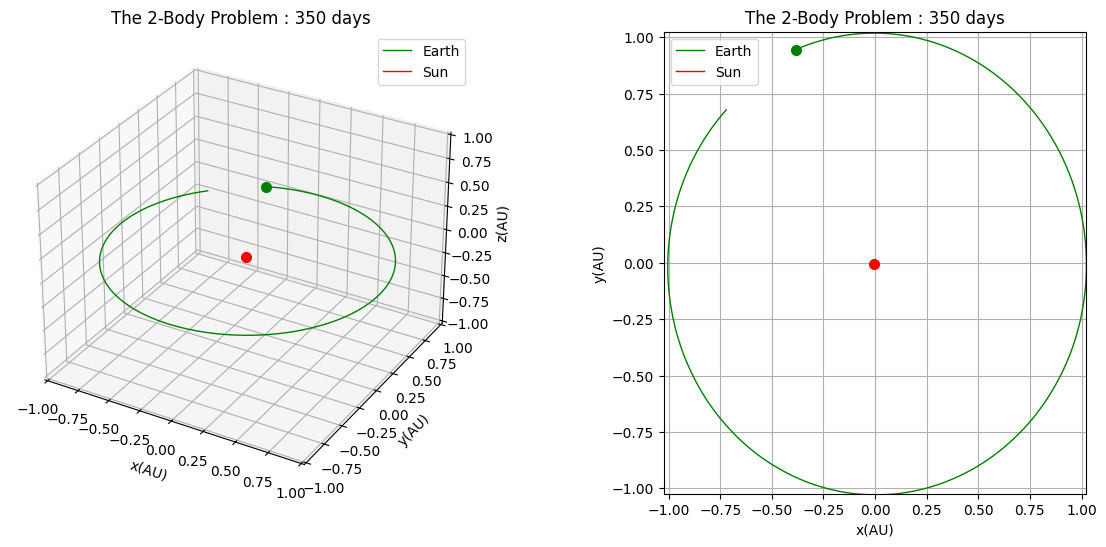

In [ ]:
sesion=session()
sesion.add_body(earth.gmfactor,earth.velociy,earth.position,'Earth',normalized=True)
sesion.add_body(sun.gmfactor,sun.velociy,sun.position,'Sun',normalized=True)
sesion.info()

t_fin=350
t_span = (0, t_fin)
t_points = np.linspace(0, t_fin, 1001)
sol=sesion.plot_solution(t_span,t_points)

### 3 Body system: Sun-Earth-Jupiter

In [ ]:
jupiter=bodyAPI(name='Jupiter',date='2024-02-06')

Earth  mass 8.887692445123495e-10  p [-7.21112705e-01  6.77542020e-01  1.77395911e-04]  v [-1.21589732e-02 -1.25180102e-02  9.42398738e-07]
Sun  mass 0.0002959122082855911  p [-0.00778802 -0.00315501  0.00020856]  v [ 5.12223291e-06 -6.77226199e-06 -5.19553746e-08]
Jupiter  mass 2.824760919377649e-07  p [ 3.2829848   3.74966485 -0.08900551]  v [-0.0057615   0.00532818  0.00010677]
Calc time:  0.0158


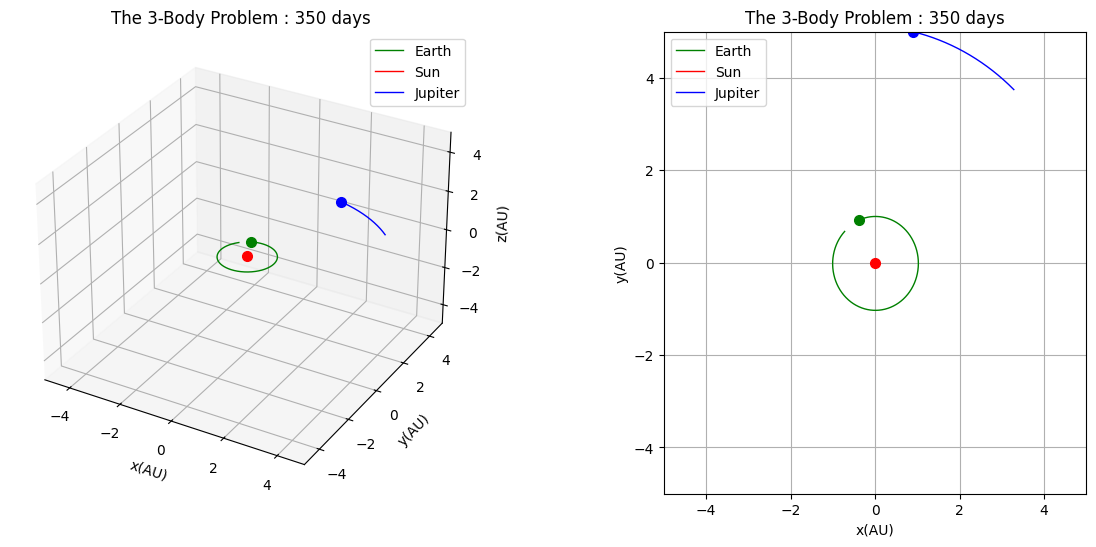

Calc time:  0.0099


In [ ]:
sesion=session()
sesion.add_body(earth.gmfactor,earth.velociy,earth.position,'Earth',normalized=True)
sesion.add_body(sun.gmfactor,sun.velociy,sun.position,'Sun',normalized=True)
sesion.add_body(jupiter.gmfactor,jupiter.velociy,jupiter.position,'Jupiter',normalized=True)
sesion.info()

t_fin=350
t_span = (0, t_fin)
t_points = np.linspace(0, t_fin, 3001)
sol=sesion.plot_solution(t_span,t_points)

Prediction

In [192]:
date_formated = datetime.strptime('2024-02-06', '%Y-%m-%d')
date_future= date_formated + timedelta(days=350)
date_future_str=date_future.strftime('%Y-%m-%d')

earth_target=bodyAPI(name='Earth',date=date_future_str)

print(earth_target.position/au)
print(sol['y'][:3,-1])
err=100*np.abs(earth_target.position/au-sol['y'][:3,-1])/np.abs(earth_target.position/au)
print(f'Error X: {round(err[0],4)}%  Error Y: {round(err[1],4)}%  Error Z: {round(err[2],4)}%')

Gettin data from the API for Earth...
OK
[-5.10098432e-01  8.39941830e-01  1.33347556e-04]
[-3.90564911e-01  9.20254188e-01  1.27288678e-04]
Error X: 23.4334%  Error Y: 9.5617%  Error Z: 4.5437%


What happens if i add the moon?     
### 4 Bodies: Sun-earth-moon-Jupiter

In [ ]:
moon=bodyAPI(name='Moon',date='2024-02-06')


Gettin data from the API for Jupiter...
OK
Gettin data from the API for Moon...
OK


Earth  mass 8.887692445123495e-10  p [-7.21112705e-01  6.77542020e-01  1.77395911e-04]  v [-1.21589732e-02 -1.25180102e-02  9.42398738e-07]
Moon  mass 1.0931894507058456e-11  p [-7.21433603e-01  6.75053535e-01 -2.51181902e-05]  v [-1.15579160e-02 -1.25516020e-02 -1.78839453e-05]
Sun  mass 0.0002959122082855911  p [-0.00778802 -0.00315501  0.00020856]  v [ 5.12223291e-06 -6.77226199e-06 -5.19553746e-08]
Jupiter  mass 2.824760919377649e-07  p [ 3.2829848   3.74966485 -0.08900551]  v [-0.0057615   0.00532818  0.00010677]
Calc time:  0.3289


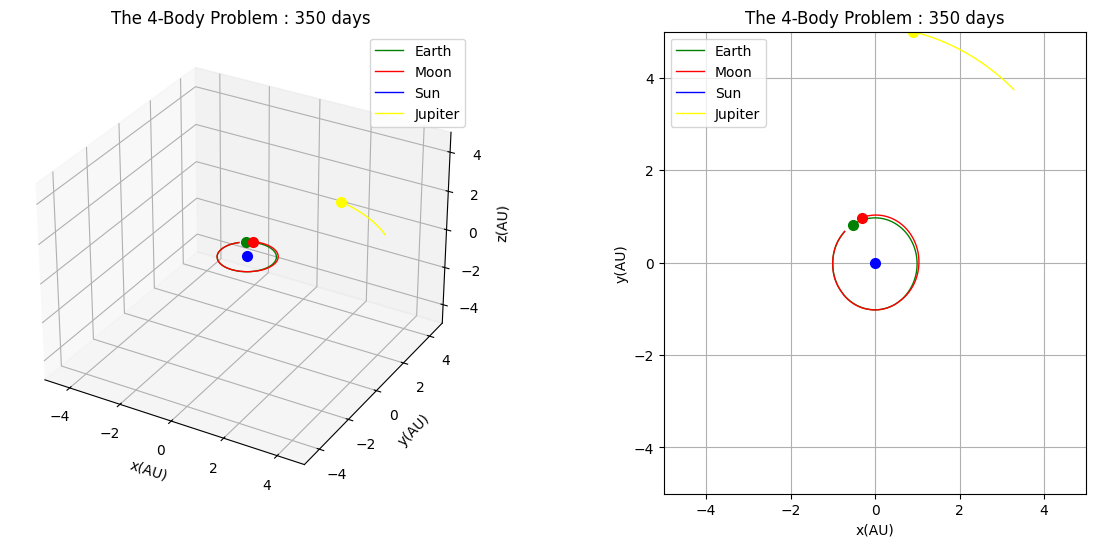

Calc time:  0.3203


In [ ]:
sesion=session()
sesion.add_body(earth.gmfactor,earth.velociy,earth.position,'Earth',normalized=True)
sesion.add_body(moon.gmfactor,moon.velociy,moon.position,'Moon',normalized=True)
sesion.add_body(sun.gmfactor,sun.velociy,sun.position,'Sun',normalized=True)
sesion.add_body(jupiter.gmfactor,jupiter.velociy,jupiter.position,'Jupiter',normalized=True)
sesion.info()

t_fin=350
t_span = (0, t_fin)
t_points = np.linspace(0, t_fin, 3001)
sol=sesion.plot_solution(t_span,t_points)


Prediction

In [ ]:
date_formated = datetime.strptime('2024-02-06', '%Y-%m-%d')
date_future= date_formated + timedelta(days=350)
date_future_str=date_future.strftime('%Y-%m-%d')

earth_target=bodyAPI(name='Earth',date=date_future_str)


Gettin data from the API for Earth...
OK
Gettin data from the API for Sun...
OK
Gettin data from the API for Jupiter...
OK


In [194]:
print(earth_target.position/au)
print(sol['y'][:3,-1])
err=100*np.abs(earth_target.position/au-sol['y'][:3,-1])/np.abs(earth_target.position/au)
print(f'Error X: {round(err[0],4)}%  Error Y: {round(err[1],4)}%  Error Z: {round(err[2],4)}%')

[-5.10098432e-01  8.39941830e-01  1.33347556e-04]
[-5.26051468e-01  8.22889759e-01  1.36290724e-04]
Error X: 3.1274%  Error Y: 2.0301%  Error Z: 2.2071%


Better results, only 3% of relative error for a prediction of 350 days in this simple model is awesome.

### Solar System

In [183]:
mercury=bodyAPI(name='Mercury',date='2024-02-06')
venus=bodyAPI(name='Venus',date='2024-02-06')
mars=bodyAPI(name='Mars',date='2024-02-06')
saturn=bodyAPI(name='Saturn',date='2024-02-06')

Gettin data from the API for Mercury...
OK
Gettin data from the API for Venus...
OK
Gettin data from the API for Mars...
OK
Gettin data from the API for Saturn...
OK


Earth  mass 8.887692445123495e-10  p [-7.21112705e-01  6.77542020e-01  1.77395911e-04]  v [-1.21589732e-02 -1.25180102e-02  9.42398738e-07]
Moon  mass 1.0931894507058456e-11  p [-7.21433603e-01  6.75053535e-01 -2.51181902e-05]  v [-1.15579160e-02 -1.25516020e-02 -1.78839453e-05]
Sun  mass 0.0002959122082855911  p [-0.00778802 -0.00315501  0.00020856]  v [ 5.12223291e-06 -6.77226199e-06 -5.19553746e-08]
Jupiter  mass 2.824760919377649e-07  p [ 3.2829848   3.74966485 -0.08900551]  v [-0.0057615   0.00532818  0.00010677]
Mercury  mass 4.9125001945771564e-11  p [-0.03710504 -0.46608756 -0.03493362]  v [ 0.02243997 -0.00034686 -0.00208565]
Venus  mass 7.243452332644119e-10  p [-0.32709851 -0.65412242  0.009693  ]  v [ 0.01802625 -0.00900437 -0.00116345]
Mars  mass 9.549548695550767e-11  p [ 0.21879946 -1.42223437 -0.03508925]  v [ 0.01435102  0.00340094 -0.00028052]
Saturn  mass 8.457614822010693e-08  p [ 9.05180701 -3.53311821 -0.29896342]  v [ 0.0017177   0.00518641 -0.00015881]
Calc time

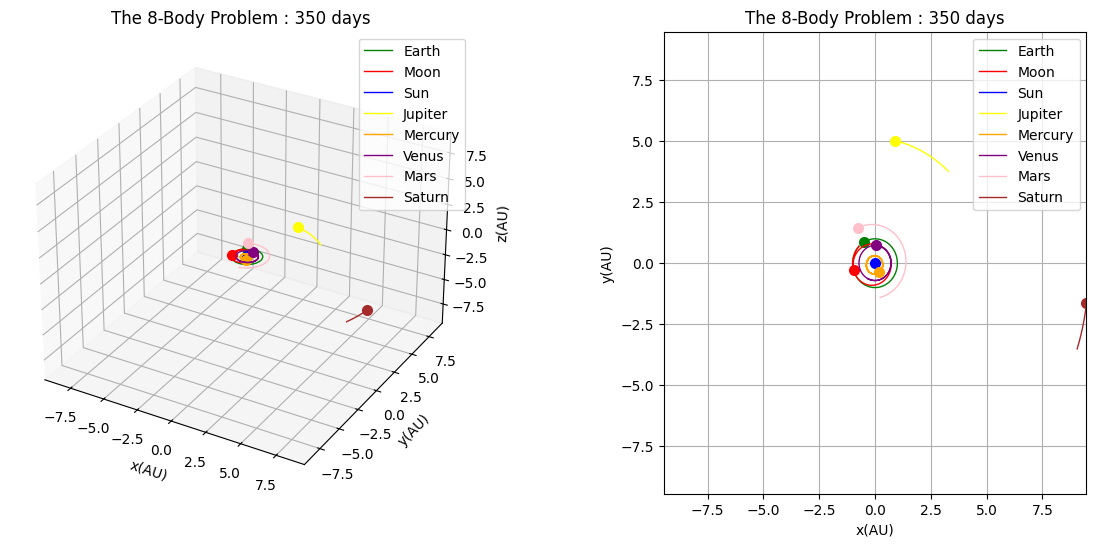

Calc time:  1.1211


In [ ]:
sesion=session()
sesion.add_body(earth.gmfactor,earth.velociy,earth.position,'Earth',normalized=True)
sesion.add_body(moon.gmfactor,moon.velociy,moon.position,'Moon',normalized=True)
sesion.add_body(sun.gmfactor,sun.velociy,sun.position,'Sun',normalized=True)
sesion.add_body(jupiter.gmfactor,jupiter.velociy,jupiter.position,'Jupiter',normalized=True)
sesion.add_body(mercury.gmfactor,mercury.velociy,mercury.position,'Mercury',normalized=True)
sesion.add_body(venus.gmfactor,venus.velociy,venus.position,'Venus',normalized=True)
sesion.add_body(mars.gmfactor,mars.velociy,mars.position,'Mars',normalized=True)
sesion.add_body(saturn.gmfactor,saturn.velociy,saturn.position,'Saturn',normalized=True)
sesion.info()

t_fin=350
t_span = (0, t_fin)
t_points = np.linspace(0, t_fin, 3001)
sol=sesion.plot_solution(t_span,t_points)

In [196]:
print(earth_target.position/au)
print(sol['y'][:3,-1])
err=100*np.abs(earth_target.position/au-sol['y'][:3,-1])/np.abs(earth_target.position/au)
print(f'Error X: {round(err[0],4)}%  Error Y: {round(err[1],4)}%  Error Z: {round(err[2],4)}%')

[-5.10098432e-01  8.39941830e-01  1.33347556e-04]
[-5.10036574e-01  8.41304304e-01  2.37406210e-04]
Error X: 0.0121%  Error Y: 0.1622%  Error Z: 78.0357%


With more planets the results in the XY plane are even better, less than 0.1%, however, i have worse results in the Z axis.

In [203]:
n=4
jupiter_target=bodyAPI(name='Jupiter',date=date_future_str)
print(jupiter_target.position/au)
print(sol['y'][3*(n-1):3*n,-1])
err=100*np.abs(jupiter_target.position/au-sol['y'][3*(n-1):3*n,-1])/np.abs(jupiter_target.position/au)
print(f'Error X: {round(err[0],4)}%  Error Y: {round(err[1],4)}%  Error Z: {round(err[2],4)}%')

Gettin data from the API for Jupiter...
OK
[ 0.900475    5.00271674 -0.04089607]
[ 0.90033811  5.00246876 -0.04090364]
Error X: 0.0152%  Error Y: 0.005%  Error Z: 0.0185%


On the other hand, Jupiter has a beterr acuracy in all axis.        
The only thing i got in mind that could affect the orbit of earth in the Z axis but not the orbit of distant planets like Jupiter is the precesion of Mercury (due to relativistics effects). So lets play the game wihtout Mercury.

### Solar System without Mercury

Earth  mass 8.887692445123495e-10  p [-7.21112705e-01  6.77542020e-01  1.77395911e-04]  v [-1.21589732e-02 -1.25180102e-02  9.42398738e-07]
Moon  mass 1.0931894507058456e-11  p [-7.21433603e-01  6.75053535e-01 -2.51181902e-05]  v [-1.15579160e-02 -1.25516020e-02 -1.78839453e-05]
Sun  mass 0.0002959122082855911  p [-0.00778802 -0.00315501  0.00020856]  v [ 5.12223291e-06 -6.77226199e-06 -5.19553746e-08]
Jupiter  mass 2.824760919377649e-07  p [ 3.2829848   3.74966485 -0.08900551]  v [-0.0057615   0.00532818  0.00010677]
Venus  mass 7.243452332644119e-10  p [-0.32709851 -0.65412242  0.009693  ]  v [ 0.01802625 -0.00900437 -0.00116345]
Mars  mass 9.549548695550767e-11  p [ 0.21879946 -1.42223437 -0.03508925]  v [ 0.01435102  0.00340094 -0.00028052]
Saturn  mass 8.457614822010693e-08  p [ 9.05180701 -3.53311821 -0.29896342]  v [ 0.0017177   0.00518641 -0.00015881]
Calc time:  0.1187


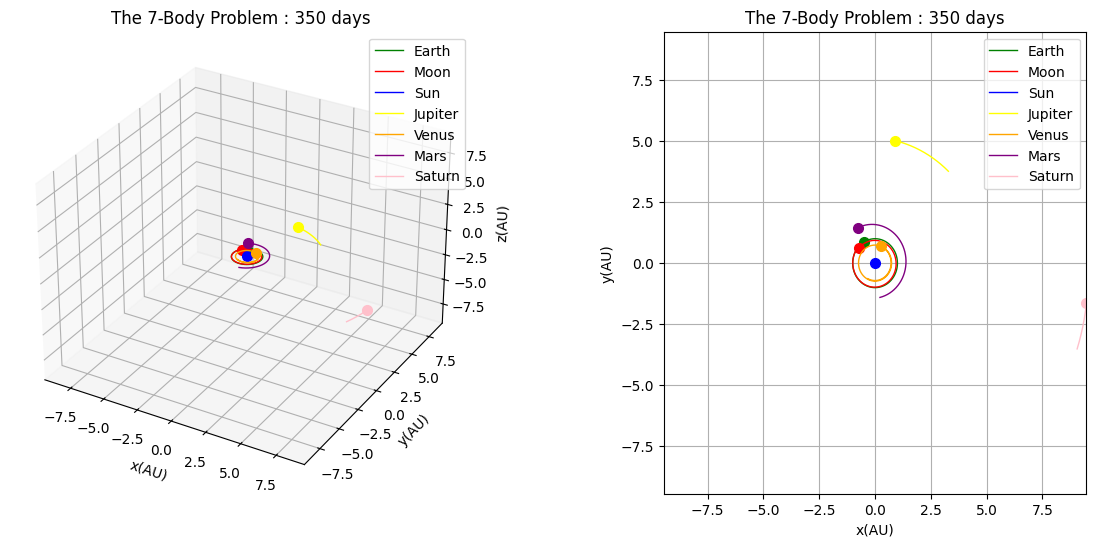

Calc time:  0.1228


In [ ]:
sesion=session()
sesion.add_body(earth.gmfactor,earth.velociy,earth.position,'Earth',normalized=True)
sesion.add_body(moon.gmfactor,moon.velociy,moon.position,'Moon',normalized=True)
sesion.add_body(sun.gmfactor,sun.velociy,sun.position,'Sun',normalized=True)
sesion.add_body(jupiter.gmfactor,jupiter.velociy,jupiter.position,'Jupiter',normalized=True)
#sesion.add_body(mercury.gmfactor,mercury.velociy,mercury.position,'Mercury',normalized=True)
sesion.add_body(venus.gmfactor,venus.velociy,venus.position,'Venus',normalized=True)
sesion.add_body(mars.gmfactor,mars.velociy,mars.position,'Mars',normalized=True)
sesion.add_body(saturn.gmfactor,saturn.velociy,saturn.position,'Saturn',normalized=True)
sesion.info()

t_fin=350
t_span = (0, t_fin)
t_points = np.linspace(0, t_fin, 3001)
sol=sesion.plot_solution(t_span,t_points)

In [205]:
print(earth_target.position/au)
print(sol['y'][:3,-1])
err=100*np.abs(earth_target.position/au-sol['y'][:3,-1])/np.abs(earth_target.position/au)
print(f'Error X: {round(err[0],4)}%  Error Y: {round(err[1],4)}%  Error Z: {round(err[2],4)}%')

[-5.10098432e-01  8.39941830e-01  1.33347556e-04]
[-4.90935345e-01  8.56755730e-01  1.37493500e-04]
Error X: 3.7567%  Error Y: 2.0018%  Error Z: 3.1091%


As i just said, Mercury was the causer of the poor acuracy on the Earth´s Z axis. The only way to make a solution is including relativistic effects, specifically the precesion of the orbit.